In [215]:
import matplotlib.pyplot as plt
import requests
import pandas as pd
import numpy as np
import csv
import os
import json
import scipy.stats as st
from numpy import array
from scipy.stats import sem
import datetime as dt
from datetime import datetime
import math
import matplotlib.animation as animation


In [239]:
#Querying the API to get the covid information
Url = "https://api.covidtracking.com/v1/states/daily.json"
Covid_Info_Response = requests.get(url)
Covid_Info_Json = Covid_Info_Response.json()
Df = pd.read_json(url)

#Drop the columns that are not needed
Covid_Info_Df=Df.drop(Df.columns[[2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,43,45,46,49,50,51,52,53,54,55]], axis=1)

#Drop the data from before Mar, 2020
Covid_Info_Df.drop(Covid_Info_Df.index[20588:] ,axis = 0, inplace=True)
Covid_Info_Df
Df.keys()

Index(['date', 'state', 'positive', 'probableCases', 'negative', 'pending',
       'totalTestResultsSource', 'totalTestResults', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered',
       'lastUpdateEt', 'dateModified', 'checkTimeEt', 'death', 'hospitalized',
       'hospitalizedDischarged', 'dateChecked', 'totalTestsViral',
       'positiveTestsViral', 'negativeTestsViral', 'positiveCasesViral',
       'deathConfirmed', 'deathProbable', 'totalTestEncountersViral',
       'totalTestsPeopleViral', 'totalTestsAntibody', 'positiveTestsAntibody',
       'negativeTestsAntibody', 'totalTestsPeopleAntibody',
       'positiveTestsPeopleAntibody', 'negativeTestsPeopleAntibody',
       'totalTestsPeopleAntigen', 'positiveTestsPeopleAntigen',
       'totalTestsAntigen', 'positiveTestsAntigen', 'fips', 'positiveIncrease',
       'negativeIncrease', 'total', 'totalTestResultsIncrease', 

In [217]:
#Converting Date into proper format
Covid_Info_Df['date'] = pd.to_datetime(Covid_Info_Df['date'], format='%Y%m%d', errors='ignore')
Covid_Info_Df


,date,state,onVentilatorCurrently,positiveIncrease,negativeIncrease,totalTestResultsIncrease,deathIncrease,hospitalizedIncrease
0,2021-03-07,AK,2.00,0,0,0,0,0
1,2021-03-07,AL,NaN,408,2087,2347,-1,0
2,2021-03-07,AR,65.00,165,3267,3380,22,11
3,2021-03-07,AS,NaN,0,0,0,0,0
4,2021-03-07,AZ,143.00,1335,13678,45110,5,44
...,...,...,...,...,...,...,...,...
20583,2020-03-01,NJ,NaN,0,0,0,0,0
20584,2020-03-01,RI,NaN,0,0,0,0,0
20585,2020-03-01,VA,NaN,0,0,2,0,0
20586,2020-03-01,WA,NaN,8,0,75,3,0


In [218]:
#Splitting the Date by Year, Month and Day. Also, Renaming the columns
Covid_Info_Df[['year','month','day']] = Covid_Info_Df.date.apply(lambda x: pd.Series(x.strftime("%Y,%m,%d").split(",")))
Covid_Info_Df = Covid_Info_Df.rename(columns={
    "date":"Date", 
    "state":"State", 
    "deathIncrease":"Deaths",
    "hospitalizedIncrease":"Hospitalized",
    "positiveIncrease":"Positive Cases",
    "negativeIncrease":"Negative Cases",
    "onVentilatorCurrently":"OnVentilator", 
    "totalTestResultsIncrease":"TotalTestResults",
})
Covid_Info_Df

,Date,State,OnVentilator,Positive Cases,Negative Cases,TotalTestResults,Deaths,Hospitalized,year,month,day
0,2021-03-07,AK,2.00,0,0,0,0,0,2021,03,07
1,2021-03-07,AL,NaN,408,2087,2347,-1,0,2021,03,07
2,2021-03-07,AR,65.00,165,3267,3380,22,11,2021,03,07
3,2021-03-07,AS,NaN,0,0,0,0,0,2021,03,07
4,2021-03-07,AZ,143.00,1335,13678,45110,5,44,2021,03,07
...,...,...,...,...,...,...,...,...,...,...,...
20583,2020-03-01,NJ,NaN,0,0,0,0,0,2020,03,01
20584,2020-03-01,RI,NaN,0,0,0,0,0,2020,03,01
20585,2020-03-01,VA,NaN,0,0,2,0,0,2020,03,01
20586,2020-03-01,WA,NaN,8,0,75,3,0,2020,03,01


In [230]:
#Grouping the covid information by Year, Month and State. This helps us to summarize the covid information by Year+Month for each state.
Grouped_Covid_Info_Df = Covid_Info_Df.groupby(['year','month','State']).agg({"Positive Cases":'sum',"Negative Cases":'sum',"OnVentilator":'sum',"TotalTestResults":'sum',"Deaths":'sum',"Hospitalized":'sum'})
Grouped_Covid_Info_Df = Grouped_Covid_Info_Df.reset_index()
Grouped_Covid_Info_Df
Result_Df = Grouped_Covid_Info_Df[Grouped_Covid_Info_Df['State'] == 'AK']
Result_Df.sort_values(by = 'Positive Cases',ascending=True)

,year,month,State,Positive Cases,Negative Cases,OnVentilator,TotalTestResults,Deaths,Hospitalized
112,2020,05,AK,108,0,5.00,32576,1,12
0,2020,03,AK,128,0,0.00,3705,3,12
56,2020,04,AK,227,0,0.00,15406,6,26
168,2020,06,AK,481,0,39.00,60490,4,18
672,2021,03,AK,897,0,21.00,51953,15,16
224,2020,07,AK,2049,0,46.00,120921,9,83
280,2020,08,AK,2293,0,152.00,115524,14,90
336,2020,09,AK,2603,0,307.00,108577,19,74
616,2021,02,AK,3391,0,173.00,179350,28,72
560,2021,01,AK,7137,0,242.00,224575,56,182


In [220]:
#Retrieving the hospital information from a csv file and drop the columns that are not needed.
Hospital_info_path = "../COVID-19-impact-on-Hospital-systems/Hospital data.csv"
Hospital_Data= pd.read_csv(Hospital_info_path)
Hospital_Data_Df = pd.DataFrame(Hospital_Data)
Hospital_Data_Df=Hospital_Data_Df.drop(Hospital_Data_Df.columns[[3]], axis=1)

Hospital_Data_Df

,State,Number_Hospitals,Staff_Beds
0,AK,10,1274
1,AL,90,15127
2,AR,51,8011
3,AS,1,0
4,AZ,78,13774
5,CA,339,73849
6,CO,58,8314
7,CT,35,8860
8,DC,7,2179
9,DE,8,2036


In [221]:
#Merging the Grouped Covid info with Hospital information to get the final clean dataset.
Clean_Covid_Data_Df = pd.merge(Grouped_Covid_Info_Df,Hospital_Data_Df)
Clean_Covid_Data_Df

,year,month,State,Positive Cases,Negative Cases,OnVentilator,TotalTestResults,Deaths,Hospitalized,Number_Hospitals,Staff_Beds
0,2020,03,AK,128,0,0.00,3705,3,12,10,1274
1,2020,04,AK,227,0,0.00,15406,6,26,10,1274
2,2020,05,AK,108,0,5.00,32576,1,12,10,1274
3,2020,06,AK,481,0,39.00,60490,4,18,10,1274
4,2020,07,AK,2049,0,46.00,120921,9,83,10,1274
...,...,...,...,...,...,...,...,...,...,...,...
723,2020,11,WY,20007,24204,0.00,135669,128,345,14,1280
724,2020,12,WY,11104,18062,0.00,82197,223,318,14,1280
725,2021,01,WY,7503,12929,0.00,133201,158,182,14,1280
726,2021,02,WY,2482,8369,0.00,1731,75,98,14,1280


In [222]:
#Calculate the total number of Positive cases, negative cases, ICU cases, and deaths for each state.
Grouped_Covid_Info_Df = Grouped_Covid_Info_Df.groupby(['State']).agg({"Positive Cases":'sum',"Negative Cases":'sum',"OnVentilator":'sum',"TotalTestResults":'sum',"Deaths":'sum',"Hospitalized":'sum'})
Grouped_Covid_Info_Df = Grouped_Covid_Info_Df.reset_index()
Clean_Covid_Hosp_Df= pd.merge(Grouped_Covid_Info_Df,Hospital_Data_Df)
Clean_Covid_Hosp_Df


,State,Positive Cases,Negative Cases,OnVentilator,TotalTestResults,Deaths,Hospitalized,Number_Hospitals,Staff_Beds
0,AK,56886,0,"2,101.00",1731620,305,1293,10,1274
1,AL,499819,1931711,0.00,2323788,10148,45976,90,15127
2,AR,324818,2480710,"34,700.00",2736436,5319,14926,51,8011
3,AS,0,2140,0.00,2140,0,0,1,0
4,AZ,826452,3072983,"112,235.00",7908072,16328,57903,78,13774
5,CA,3501341,-462,0.00,49645499,54124,0,339,73849
6,CO,436600,2199439,0.00,6415123,5989,23904,58,8314
7,CT,285330,0,0.00,6520363,7704,0,35,8860
8,DC,41419,0,"9,650.00",1261357,1030,0,7,2179
9,DE,88354,545060,0.00,1431942,1473,0,8,2036


In [229]:
#Generate a summary statistics table consisting of the mean, median, variance, standard deviation, and SEM of the Covid positive cases for each state.

# Use groupby and summary statistical methods to calculate the following properties of each State: 
Cases_group = Clean_Covid_Data_Df.groupby('State')

# mean, median, variance, standard deviation, and SEM of the Positive cases. 
Positive_Mean = Cases_group.mean()
Positive_Mean = Positive_Mean['Positive Cases']

Positive_Median = Cases_group.median()
Positive_Median = Positive_Median['Positive Cases']

Positive_std = Cases_group.std()
Positive_std = Positive_std['Positive Cases']

Positive_var = Cases_group.var()
Positive_var = Positive_var['Positive Cases']

Positive_sem = Covid_Info_Df.groupby('State').agg(['mean','sem'])
Positive_sem = Positive_sem['Positive Cases']['sem']
Positive_sem

# Assemble the resulting series into a single summary dataframe.
Summary_Statistics_Dict = {'Mean of Positive Cases':Positive_Mean, 'Median of Positive Cases':Positive_Median, 'Variance of Positive Cases': Positive_var, 'Std of Positive Cases': Positive_std, 'Sem of Positive Cases': Positive_sem}
Summary_Statistics_DF = pd.DataFrame(Summary_Statistics_Dict)
pd.options.display.float_format = '{:20,.2f}'.format

Summary_Statistics_DF

,Mean of Positive Cases,Median of Positive Cases,Variance of Positive Cases,Std of Positive Cases,Sem of Positive Cases
State,,,,,
AK,"4,375.85",2293,"28,516,230.47","5,340.06",10.18
AL,"38,447.62",33613,"1,177,242,076.42","34,310.96",63.52
AR,"24,986.00",21734,"543,777,467.33","23,319.04",45.59
AS,0.00,0,0.00,0.00,0.00
AZ,"63,573.23",27825,"5,511,433,441.03","74,239.03",137.93
CA,"269,333.92",118149,"117,981,890,539.91","343,484.92",615.31
CO,"33,584.62",13112,"1,538,175,194.92","39,219.58",71.15
CT,"21,948.46",13657,"556,145,266.44","23,582.73",67.87
DC,"3,186.08",1940,"5,663,346.41","2,379.78",4.57


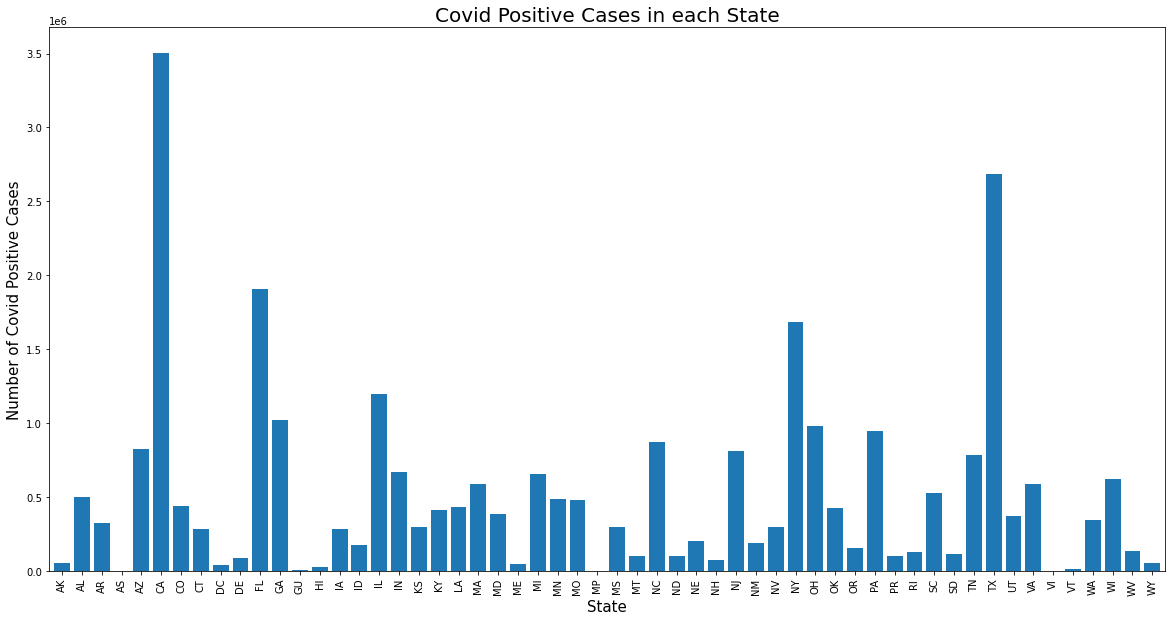

,Positive Cases
State,
AK,56886
AL,499819
AR,324818
AS,0
AZ,826452
CA,3501341
CO,436600
CT,285330
DC,41419


<Figure size 432x288 with 0 Axes>

In [231]:
#Generate a bar plot showing the total number of Covid positive cases across all states.
#y-axis values are multiplied by *1M
Barplot_df = Clean_Covid_Hosp_Df[['State','Positive Cases']]
Barplot_df = Barplot_df.set_index("State")

Barplot_df.plot(kind="bar", figsize=(20,10), legend=False, width = 0.8)
plt.title("Covid Positive Cases in each State",{'fontsize':20})
plt.ylabel("Number of Covid Positive Cases",{'fontsize':15})
plt.xlabel("State",{'fontsize':15})
plt.show()
plt.tight_layout()
Barplot_df

Text(0.5, 1.0, 'Positive cases in each state')

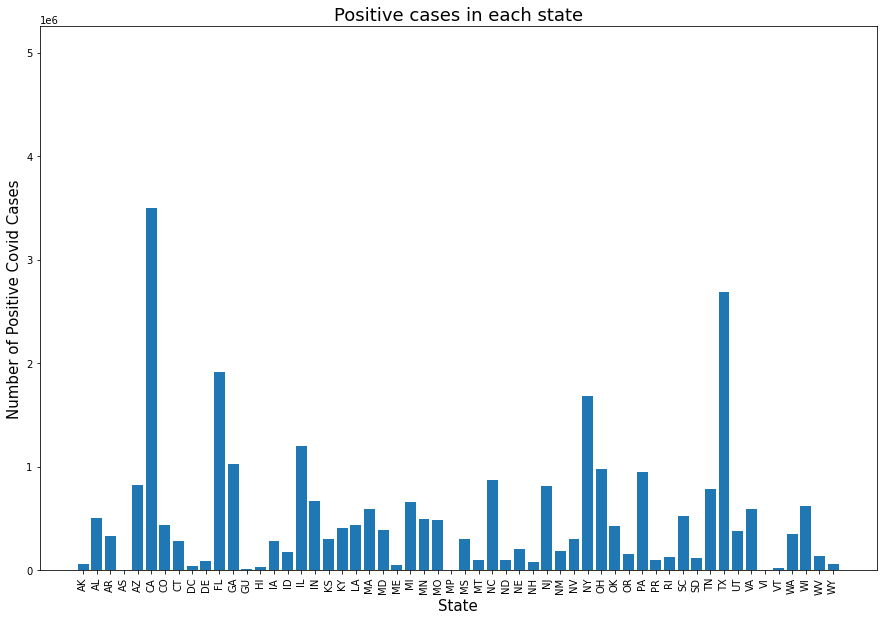

In [237]:
x_axis = np.arange(len(Barplot_df))
tick_locations = [value for value in x_axis]
plt.figure(figsize=(15,10))
low = min(Barplot_df['Positive Cases'])
high = max(Barplot_df['Positive Cases'])
plt.ylim([0, math.ceil(high+0.5*(high-low))])
plt.bar(x_axis, Barplot_df['Positive Cases'], alpha=1.0, align="center", width = 0.8)
plt.xticks(tick_locations,Barplot_df.index.values,  rotation="vertical")
plt.xlabel("State", size=15)
plt.ylabel("Number of Positive Covid Cases", size=15)
plt.title("Positive cases in each state", size=18)



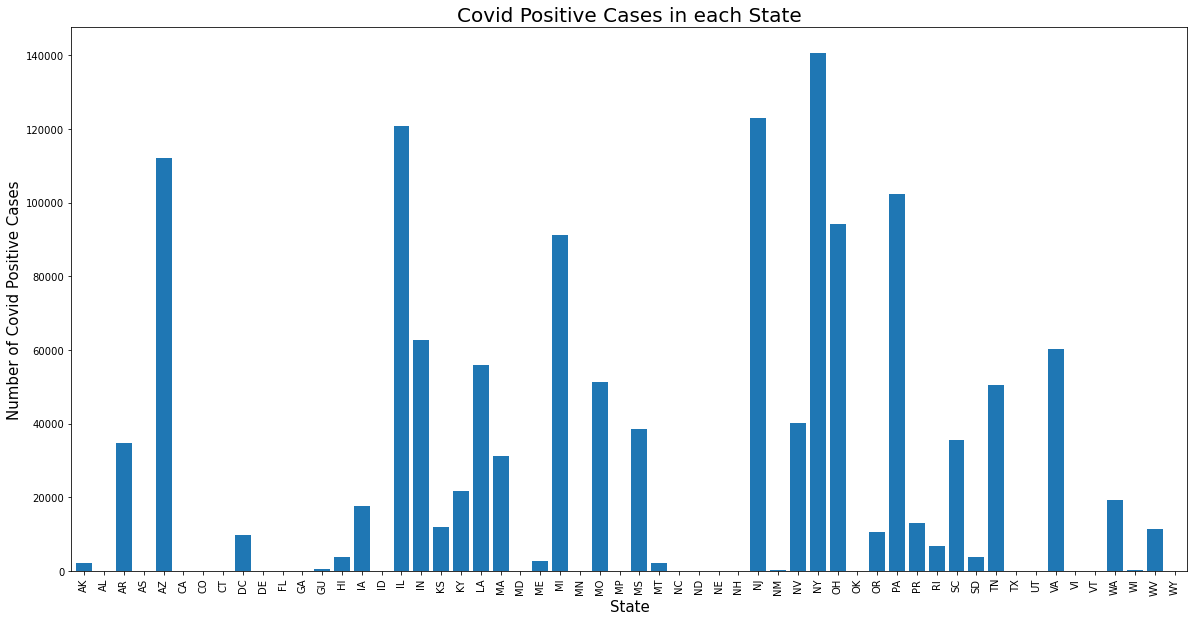

,OnVentilator
State,
AK,"2,101.00"
AL,0.00
AR,"34,700.00"
AS,0.00
AZ,"112,235.00"
CA,0.00
CO,0.00
CT,0.00
DC,"9,650.00"


<Figure size 432x288 with 0 Axes>

In [238]:
#Generate a bar plot showing the total number of ICU cases, Hospital beds for each month across all states
Barplot_ICU_df = Clean_Covid_Hosp_Df[['State','OnVentilator']]
Barplot_ICU_df = Barplot_ICU_df.set_index("State")
Barplot_ICU_df.plot(kind="bar", figsize=(20,10), legend=False, width = 0.8)
plt.title("Covid Positive Cases in each State",{'fontsize':20})
plt.ylabel("Number of Covid Positive Cases",{'fontsize':15})
plt.xlabel("State",{'fontsize':15})
plt.show()
plt.tight_layout()
Barplot_ICU_df

In [ ]:
#Generate Line chart to show the Positive cases from Mar,2020 to Feb, 2021 across all states